In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path

from doodle_dataset import DoodleDataset
from doodle_parsing_utils import *
from doodle_predictor import DoodlePredictor, calculate_loss
from doodle_predictor_config import DoodlePredictorConfig
from doodle_dataset import encode_stroke_data, decode_stroke_data

torch.cuda.empty_cache()

In [3]:
config = DoodlePredictorConfig("./configs/base_config.json")

In [4]:
doodle_predictor = DoodlePredictor(config).to(config.device)
doodle_predictor.eval()

print("Model Loaded")

Model Loaded


In [5]:
doodle_predictor.load_state_dict(torch.load("./models/only_normalize_x/model_state_dict"))

<All keys matched successfully>

In [6]:
mean = np.array([1.1523420567837017, -1.7892017952608004])
std = np.array([17.661761786706826, 19.484090706411575])

test_dataset = DoodleDataset(
    Path("./dataset"),
    split="train",
    block_size=config.block_size - 1,
    scaled_size=config.scaled_size,
    device=config.device,
    mean=mean, # Normalization
    std=std,
)

Preprocessing Data:


1it [00:02,  2.86s/it]

Calculating CLIP Embeddings


In [7]:
def complete_doodle(model: DoodlePredictor, doodle: torch.Tensor, classname_embedding: torch.Tensor, max_strokes=100):
    full_doodle = doodle.clone().to(config.device)
    original_doodle_length = full_doodle.shape[0]

    num_additional_strokes = 0
    doodle_finished = False
    while num_additional_strokes <= max_strokes or doodle_finished:
        new_stroke = model(
            full_doodle[num_additional_strokes:].unsqueeze(0).to(config.device).float(),
            classname_embedding.unsqueeze(0).to(config.device).float()
        )[0, -1, :]

        # Decode the one-hot pen state
        new_stroke[2:] = new_stroke[2:] == torch.max(new_stroke[2:])
        new_stroke = new_stroke.unsqueeze(0).to(config.device)

        full_doodle = torch.cat([full_doodle, new_stroke])

        doodle_finished = new_stroke[0, -1].item()
        num_additional_strokes += 1
    
    full_doodle = full_doodle.cpu().detach()
    full_doodle[:original_doodle_length, :] = test_dataset._denormalize_drawing(full_doodle[:original_doodle_length, :])
    return full_doodle

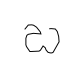

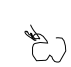

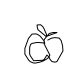

In [21]:
gt_doodle, xs, ys, classname_embedding = test_dataset[random.randint(0, len(test_dataset) - 1)]
full_doodle = complete_doodle(doodle_predictor, xs, classname_embedding, max_strokes=100)
decoded_doodle = decode_stroke_data(full_doodle.detach().cpu())
draw_strokes(decoded_doodle[:xs.shape[0]], factor=5)
draw_strokes(decoded_doodle, factor=5)
draw_strokes(decode_stroke_data(gt_doodle), factor=5)

In [14]:
gt_doodle

array([[-17, -16,   1,   0,   0],
       [-12,   0,   1,   0,   0],
       [-30,  11,   1,   0,   0],
       [-39,  27,   1,   0,   0],
       [ -6,   7,   1,   0,   0],
       [ -2,  12,   1,   0,   0],
       [  5,  19,   1,   0,   0],
       [  8,  11,   1,   0,   0],
       [ 31,   8,   1,   0,   0],
       [ 50,   8,   1,   0,   0],
       [ 47,  -8,   1,   0,   0],
       [ 51, -17,   1,   0,   0],
       [  5, -14,   1,   0,   0],
       [  0, -14,   1,   0,   0],
       [ -6,  -8,   1,   0,   0],
       [-17, -13,   1,   0,   0],
       [-14,  -5,   1,   0,   0],
       [-31,  -6,   1,   0,   0],
       [-13,   0,   1,   0,   0],
       [-13,   6,   1,   0,   0],
       [ -1,  -1,   1,   0,   0],
       [  0, -22,   1,   0,   0],
       [ -9, -65,   1,   0,   0],
       [  0,  -6,   1,   0,   0],
       [  6, -19,   1,   0,   0],
       [  3,  98,   1,   0,   0],
       [  6, -31,   1,   0,   0],
       [ 12, -15,   1,   0,   0],
       [  8,   0,   1,   0,   0],
       [ 14,  

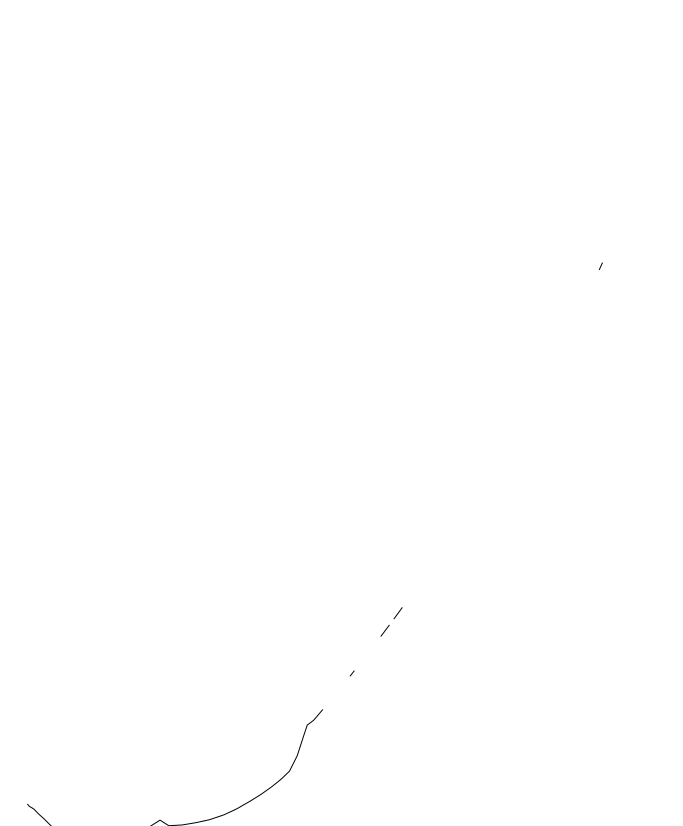

In [10]:
# Random model performance

config = DoodlePredictorConfig("./configs/base_config.json")
random_doodle_predictor = DoodlePredictor(config).to(config.device)
random_doodle = complete_doodle(random_doodle_predictor, xs, classname_embedding)

random_decoded_doodle = decode_stroke_data(random_doodle.detach().cpu())

draw_strokes(random_decoded_doodle, factor=5)
